## TODO

1. Implement perfect statevector simulation, for perfect kernel entries.
2. Implement a measure of peak width W($\gamma$)
3. Implement a measure of average gradient value $\langle G \rangle$
4. Check the W($\gamma$) and $\langle G \rangle$ as a function of shot noise (number of shots)
5. Check the W($\gamma$) and $\langle G \rangle$ as a function of N
6. Check the W($\gamma$) and $\langle G \rangle$ as a function of perturbations of x

## Imports

In [1]:
import pandas as pd
#from pennylane 
import numpy as np
import matplotlib.pyplot as plt

import copy

from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA

from qiskit import QuantumCircuit, assemble
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.circuit import Parameter

from matplotlib.colors import ListedColormap

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['font.size'] = 20

In [9]:
def matrix_target_alignment(K, Y, rescale_class_labels=True):
    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    #####
    labels = _Y.copy()
    classes = np.unique(labels)
    centered_labels = (labels - classes.mean())
    _Y = np.array(centered_labels/centered_labels.max())
    #####

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

In [2]:
def analytic_kernel_entry(x1, x2, gamma):
    return((np.cos(x1*gamma/2)*np.cos(x2*gamma/2)+np.sin(x1*gamma/2)*np.sin(x2*gamma/2))**2)

def get_analytic_kernel(x, gamma):
    kernel = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(i):
            x1_value = x[i]
            x2_value = x[j]
            #print("x1: ", x1_value, "x2: ", x2_value)
            kernel[i,j] = analytic_kernel_entry(x1= x1_value, x2= x2_value, gamma=gamma)
    kernel = kernel+np.transpose(kernel) + np.identity(len(x))
    return(kernel)

def analytic_TA(x,y,gamma):
    K = get_analytic_kernel(x, gamma)
    return(matrix_target_alignment(K, y))

## Setup

Creating the beads

In [3]:
N = 20
x = np.linspace(0,1,N)
y = (-1)**np.linspace(0,N-1,N)

In [4]:
sim = Aer.get_backend('aer_simulator')

In [5]:
def qubit_map(phi):
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.p(phi, 0)
    qc.h(0)
    return(qc)

In [6]:
def kernel_map():
    x1 = Parameter('x1')
    x2 = Parameter('x2')
    phi = Parameter('Φ')
    qc = QuantumCircuit(1,1)
    qc.h(0)
    qc.p(phi*x1, 0)
    qc.p(-1.0*phi*x2,0)
    qc.h(0)
    qc.measure(0, 0)
    return(x1, x2, phi, qc)

In [7]:
def get_kernel_entry(qc, x1, x1_value, x2, x2_value, phi, phi_value, sim = Aer.get_backend('aer_simulator')): #, x1 = Parameter('x1'), x2 =  Parameter('x2'), phi = Parameter('Φ')
    qc_bound = qc.bind_parameters({x1:float(x1_value), x2:float(x2_value), phi:float(phi_value)})
    qobj = assemble(qc_bound)  # Assemble circuit into a Qobj that can be run
    counts = sim.run(qobj).result().get_counts()  # Do the simulation, returning the state vector
    if(counts.get('0')):
        kernel_element = counts.get('0')/(sum(counts[item] for item in counts))
    else:
        kernel_element = 0
    return(kernel_element)

In [8]:
x1, x2, phi, qc_test = kernel_map()

In [9]:
def get_kernel(x, phi_value):
    x1, x2, phi, qc_out = kernel_map()
    #return(qc_out.draw(output='mpl'))
    kernel = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(i):
            x1_value = x[i]
            x2_value = x[j]
            #print("x1: ", x1_value, "x2: ", x2_value)
            kernel[i,j] = get_kernel_entry(qc= qc_out, x1= x1, x1_value= x1_value, x2= x2, x2_value= x2_value, phi= phi, phi_value = phi_value)
    kernel = kernel+np.transpose(kernel) + np.identity(len(x))
    return(kernel)

In [10]:
def matrix_target_alignment(K, Y, rescale_class_labels=True):
    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    #####
    labels = _Y.copy()
    classes = np.unique(labels)
    centered_labels = (labels - classes.mean())
    _Y = np.array(centered_labels/centered_labels.max())
    #####

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

Target kernel alignment landscape

In [11]:
def loss(phi_val):
    return( - matrix_target_alignment(get_kernel(x, phi_val), y))

def analytic_TA(x,y,gamma):
    K = get_analytic_kernel(x, gamma)
    return(matrix_target_alignment(K, y))

In [25]:
startpoint = 0
endpoint = 2*np.pi*(N-1)
points_number = 150
param_test = np.linspace(startpoint,endpoint, points_number)

In [26]:
Target_a = []
for item in param_test:
    Target_a.append(-loss(item))

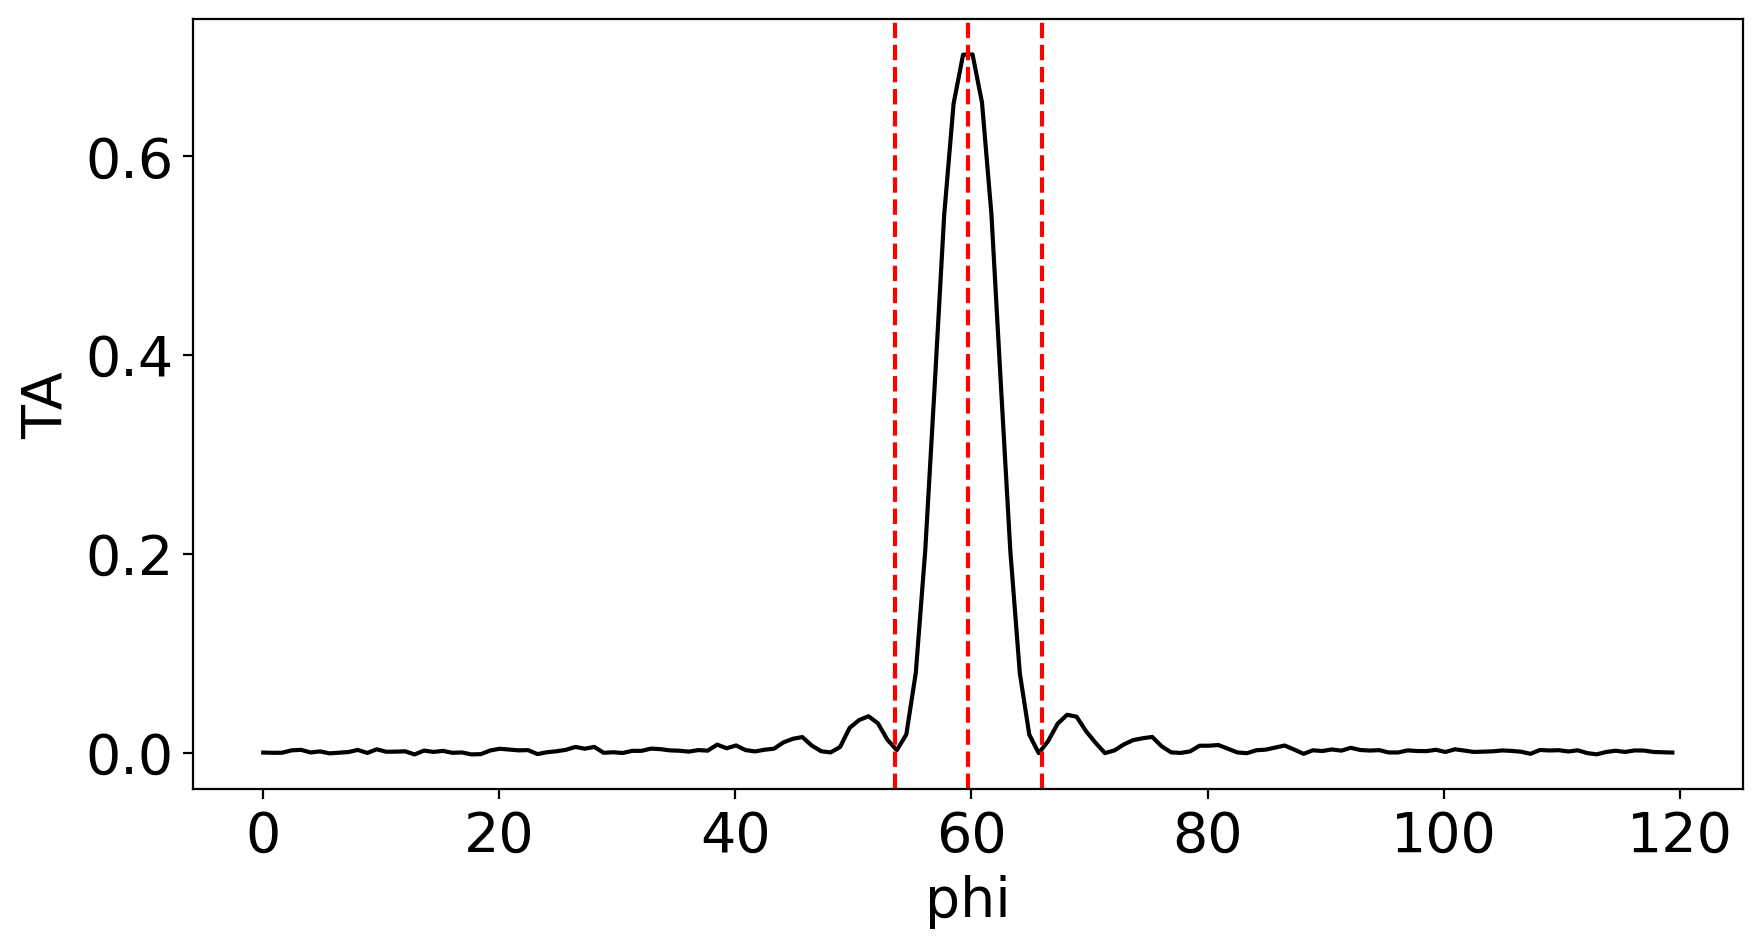

In [27]:
plt.plot(param_test, Target_a, c="k")
plt.xlabel("phi")
plt.ylabel("TA")
plt.axvline(x=np.pi*(N-1), c='red', linestyle='--')
plt.axvline(x=53.5, c='red', linestyle='--')
plt.axvline(x=66, c='red', linestyle='--')
plt.show()

# Analytic considerations

In [15]:
N = 50
x = np.linspace(0,1,N)
y = (-1)**np.linspace(0,N-1,N)

In [16]:
startpoint = 0
endpoint = 2*np.pi*(N-1)
points_number = 500
param_test = np.linspace(startpoint,endpoint, points_number)
a_TA = [analytic_TA(x,y,gamma) for gamma in param_test]

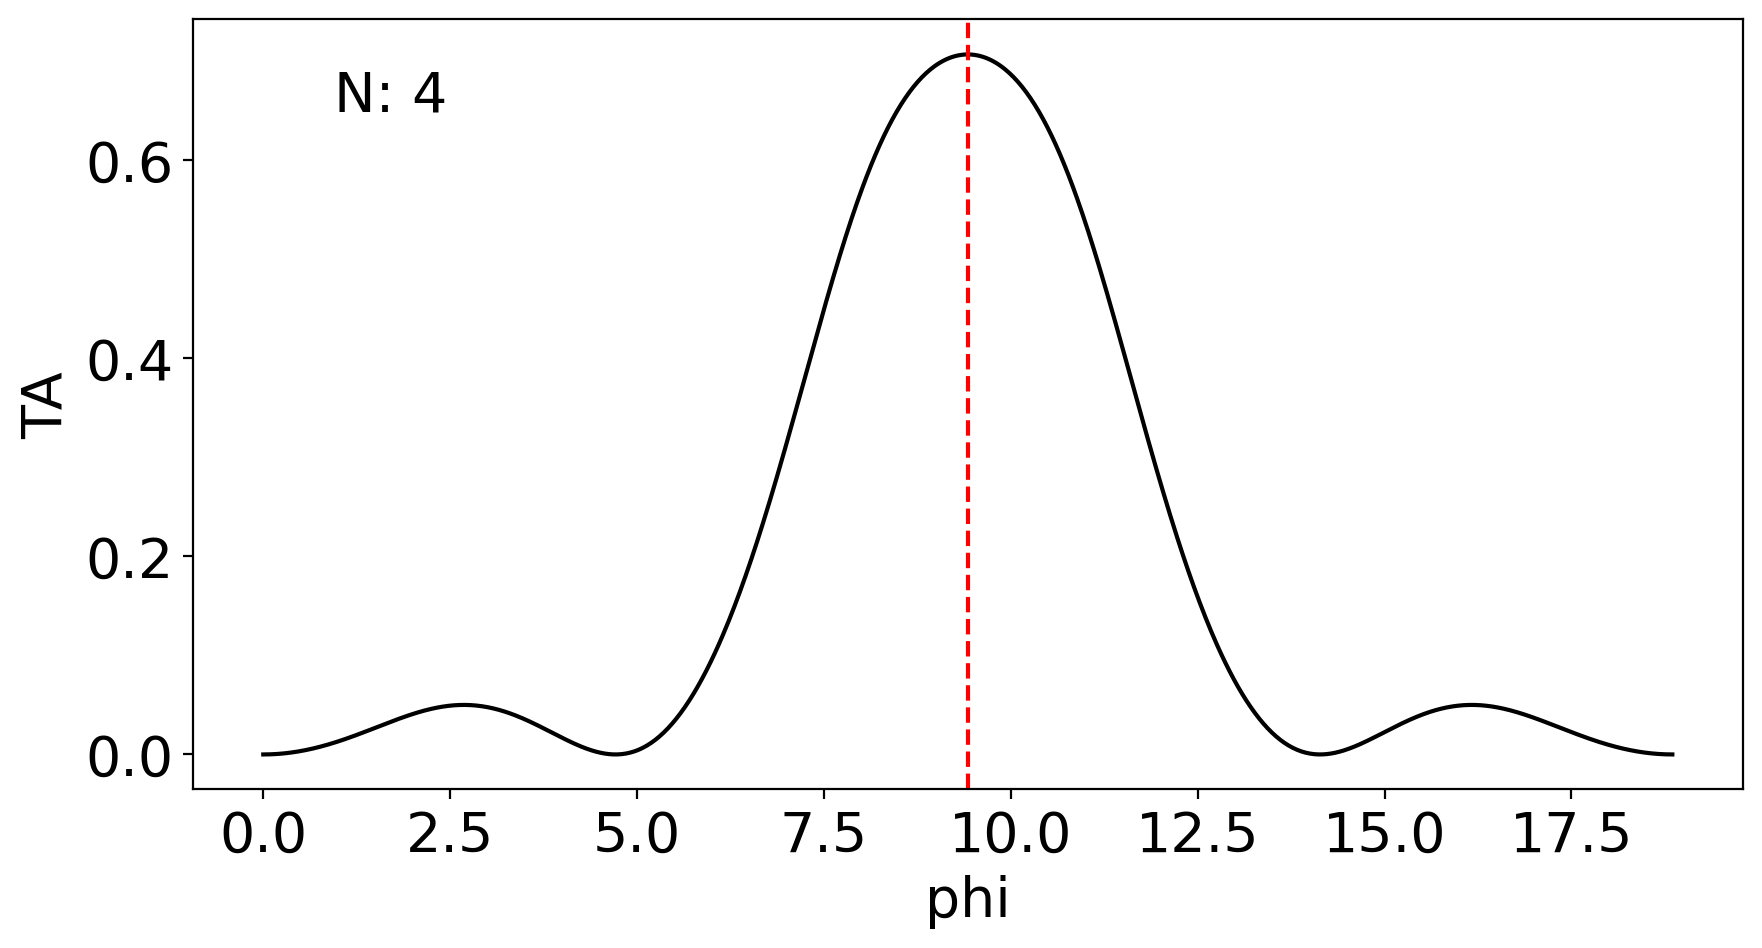

In [27]:
fig = plt.figure()
plt.plot(param_test, a_TA, c="k")
plt.xlabel("phi")
plt.ylabel("TA")
plt.text(x=(0.05*param_test[-1]), y=0.65, s='N: '+str(N))
plt.axvline(x=np.pi*(N-1), c='red', linestyle='--')
plt.show()

In [5]:
def diff(x,y):
    difs = []
    x_step = x[1]-x[0]
    for i in range(len(x)-1):
        difs.append((y[i+1]-y[i])/x_step)
    return(difs)

In [6]:
def area(x, y):
    #Only for positive functions
    x_step = x[1]-x[0]
    A = 0
    for i in range(len(x)-1):
        A += y[i]*x_step + x_step*(y[i+1]-y[i])/2
    return(A)


In [36]:
def save_TA_plot(param_test, a_TA, N):
    #if(N<10):
    #    img_id = '00' + str(N)
    #elif(N<100):
    #    img_id = '0' + str(N)
    #else:
    #    img_id = str(N)
    img_id = str(N)
    fig = plt.figure()
    plt.plot(param_test, a_TA, c="k")
    plt.xlabel("gamma")
    plt.ylabel("TA")
    plt.text(x=(0.05*param_test[-1]), y=0.65, s='N: '+str(N))
    #plt.axvline(x=np.pi*(N-1), c='red', linestyle='--')
    plt.savefig("images/TA-" + img_id + ".png")
    fig.clear()

In [37]:
Ns = []
dens = []
var_diffs = []

for n in range(2,20):
    N = 2*n
    if(N%10==0): print(N)
    x = np.linspace(0,1,N)
    y = (-1)**np.linspace(0,N-1,N)
    startpoint = 0
    endpoint = 2*np.pi*(N-1)
    points_number = 1000
    param_test = np.linspace(startpoint,endpoint, points_number)
    a_TA = [analytic_TA(x,y,gamma) for gamma in param_test]
    dens.append(area(param_test, a_TA)/(param_test[-1]-param_test[0]))
    var_diffs.append(np.var(diff(param_test, a_TA)))
    Ns.append(N)
    save_TA_plot(param_test=param_test, a_TA=a_TA, N=N)

10
20
30


<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

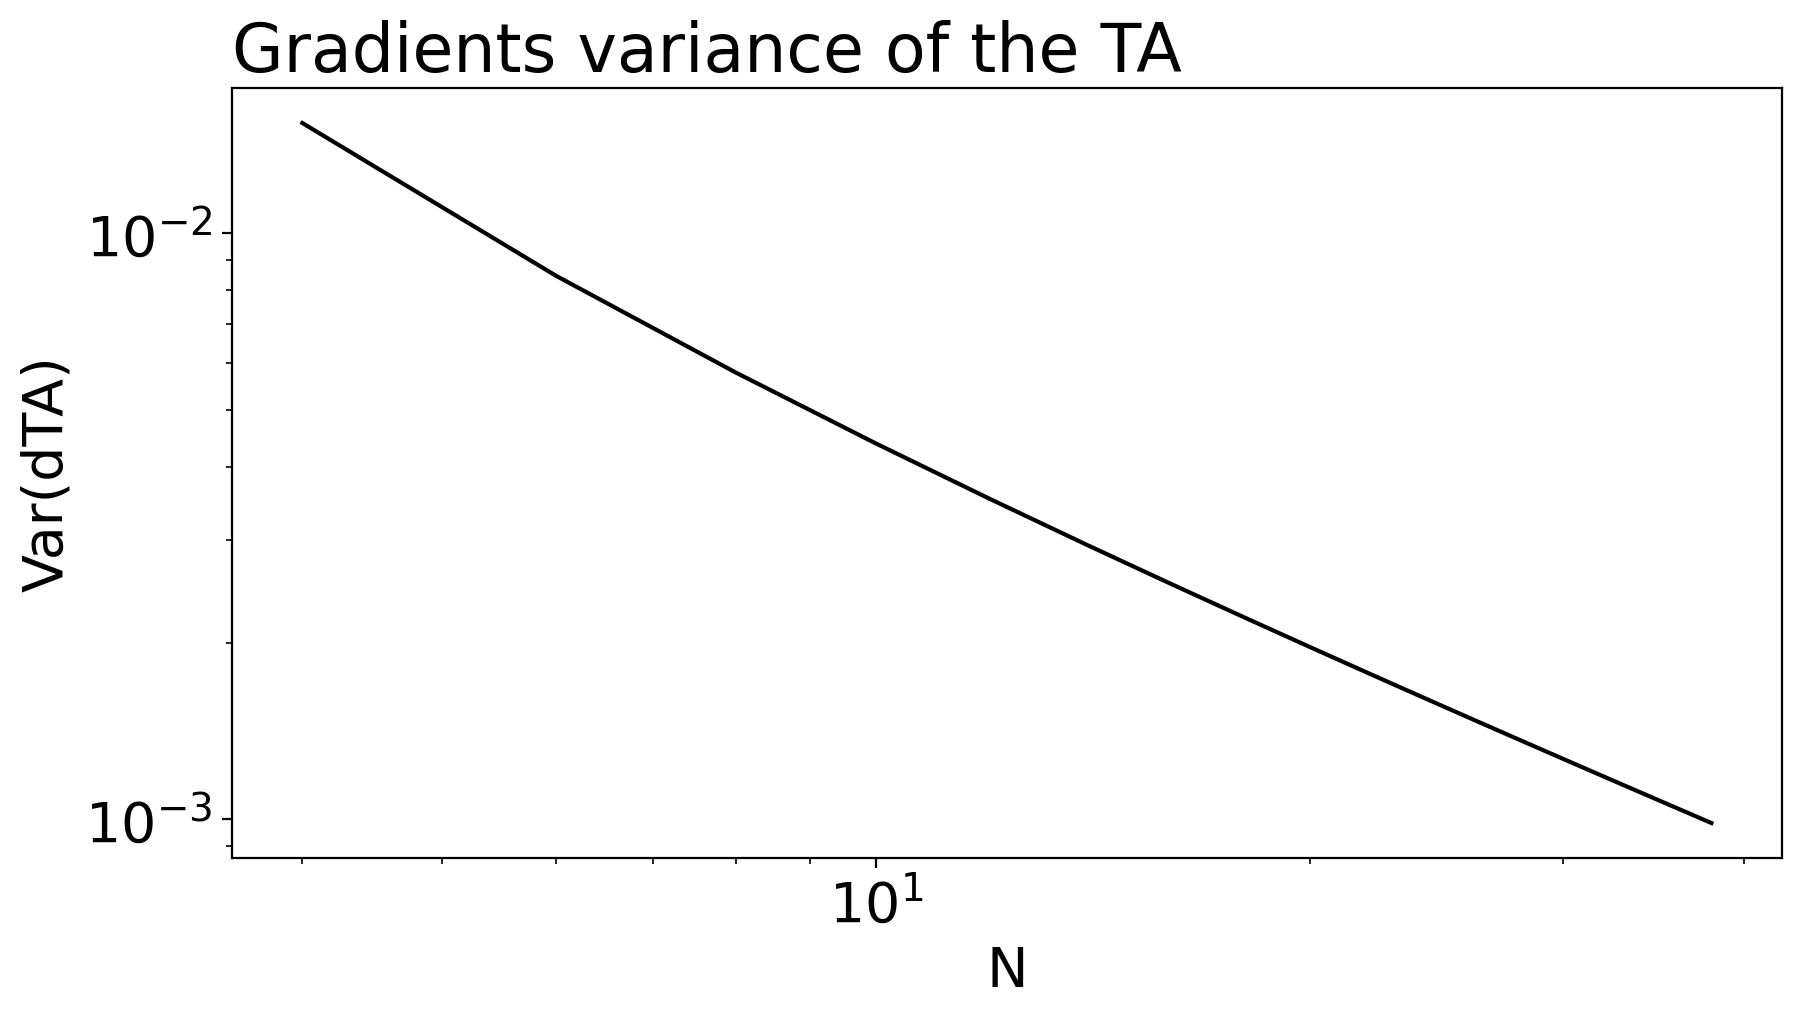

In [13]:
plt.plot(Ns,var_diffs, c='black')
plt.title('Gradients variance of the TA', loc='left')
plt.ylabel('Var(dTA)')
plt.xlabel('N')
plt.xscale('log')
plt.yscale('log')
plt.show()

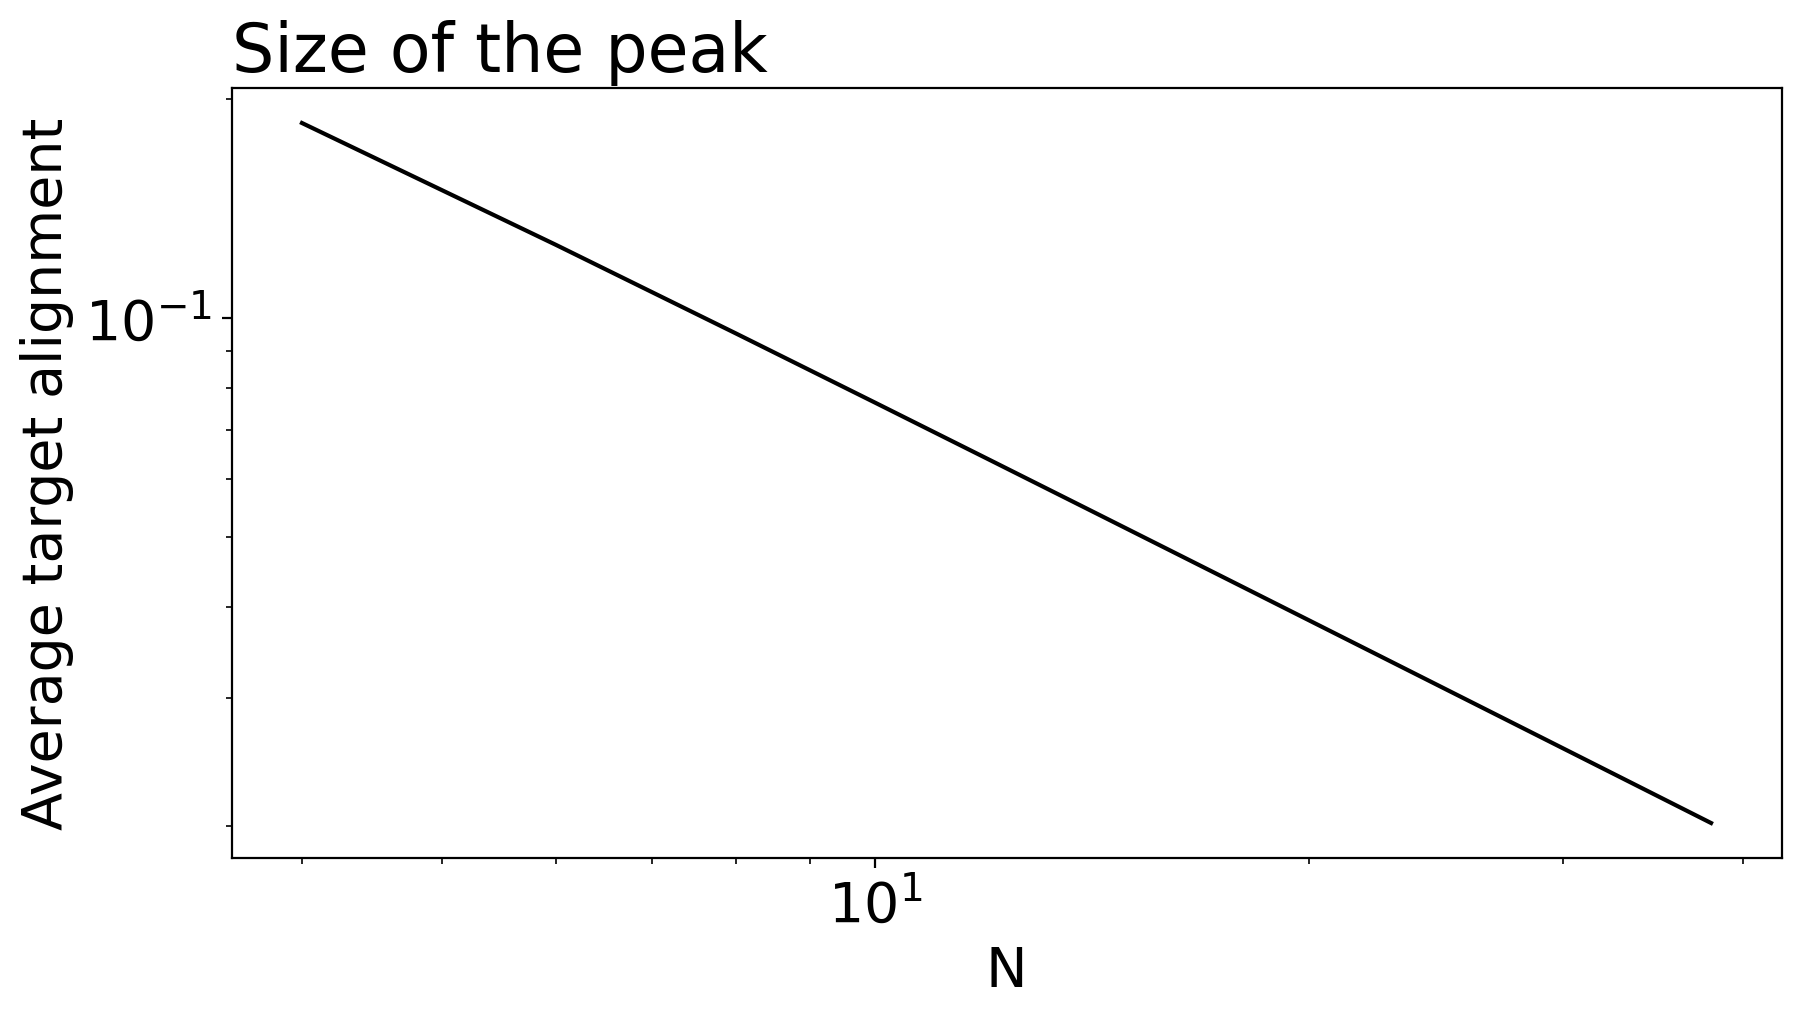

In [12]:
plt.plot(Ns,dens, c='black')
plt.title('Size of the peak', loc='left')
plt.ylabel('Average target alignment')
plt.xlabel('N')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [99]:
for n in range(20,100):
    N = 2*n
    x = np.linspace(0,1,N)
    y = (-1)**np.linspace(0,N-1,N)
    startpoint = 0
    endpoint = 2*np.pi*(N-1)
    points_number = 1000
    param_test = np.linspace(startpoint,endpoint, points_number)
    a_TA = [analytic_TA(x,y,gamma) for gamma in param_test]
    dens.append(area(param_test, a_TA)/(param_test[-1]-param_test[0]))
    Ns.append(N)

KeyboardInterrupt: 

In [105]:
Ns = [4, 6,8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104,106, 108, 110, 112, 114,116,118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138]
dens = [0.18512642817613634,
 0.1259426805647093,
 0.09515038980966826,
 0.07638160772392769,
 0.06377065105920332,
 0.054722525499495814,
 0.047917509431275304,
 0.04261489775211796,
 0.038367304708231,
 0.03488872484065357,
 0.03198785979427138,
 0.02953194800121364,
 0.02742598238325081,
 0.02560018921733728,
 0.024002177254238796,
 0.022591844804598946,
 0.02133797750075523,
 0.020215916545998434,
 0.019205924221291557,
 0.0182920150306669,
 0.01746110478722027,
 0.016702381147115457,
 0.01600683116780504,
 0.015366882026487269,
 0.014776124497957403,
 0.014229097778117924,
 0.013721120344743635,
 0.013248155761873243,
 0.01280670528714432,
 0.01239372123867112,
 0.012006536586536136,
 0.011642807331726986,
 0.011300465042977785,
 0.010977677522233996,
 0.010672816019860056,
 0.010384427761695868,
 0.010111212810394102,
 0.009852004483790864,
 0.009605752708359758,
 0.009371509807043857,
 0.009148418316048021,
 0.008935700500538487,
 0.008732649299157428,
 0.008538620475241229,
 0.008353025791229924,
 0.008175327053970763,
 0.00800503090398305,
 0.007841684242462899,
 0.00768487020679084,
 0.0075342046192962715,
 0.007389332845602987,
 0.007249927008488492,
 0.0071156835111951255,
 0.0069863208308298475,
 0.006861577548108182,
 0.0067412105844319985,
 0.0066249936212883255,
 0.006512715680345047,
 0.006404179845496361,
 0.006299202110564843,
 0.0061976103384655526,
 0.006099243319440949,
 0.006003949917526291,
 0.005911588295743093,
 0.005822025211672958,
 0.00573513537606558,
 0.005650800868000811,
 0.00556891060087896]

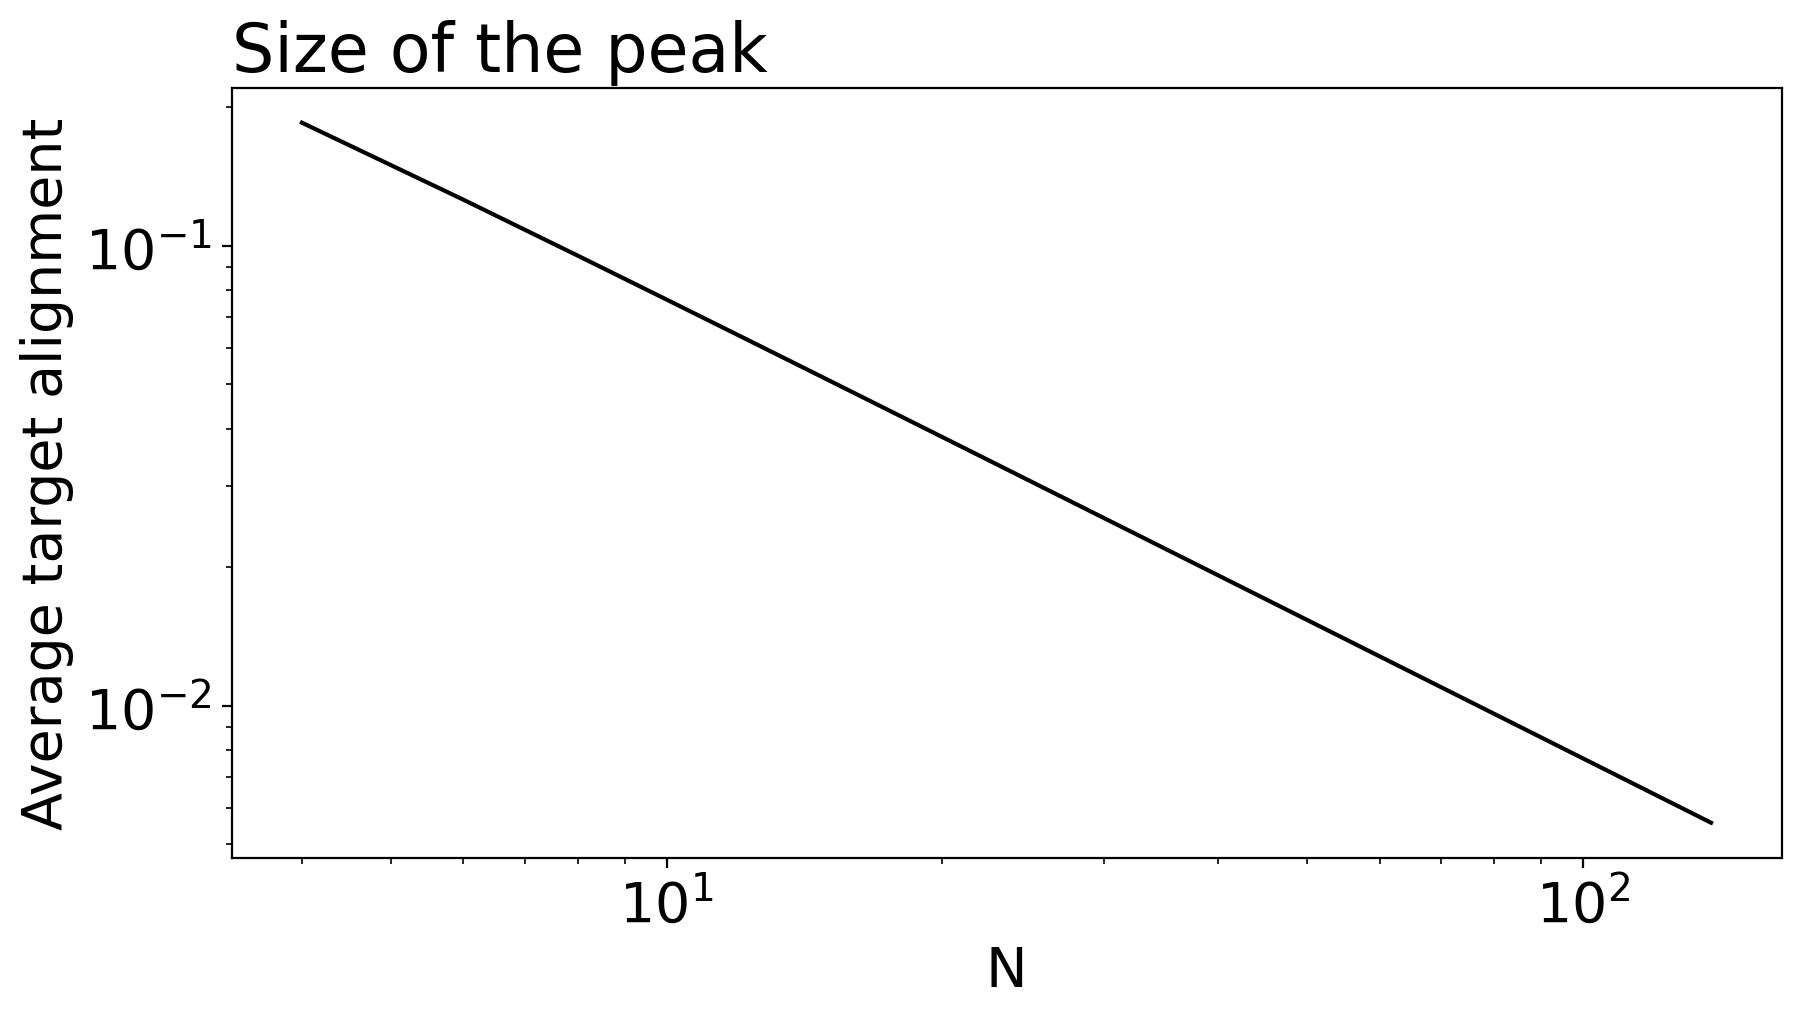

In [108]:
plt.plot(Ns,dens, c='black')
plt.title('Size of the peak', loc='left')
plt.ylabel('Average target alignment')
plt.xlabel('N')
plt.xscale('log')
plt.yscale('log')
plt.show()